In [1]:
# OpenCV and Math
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Python 
from collections import defaultdict
from pathlib import Path
import logging
import math
import time

# Our module
from module.getSwt import get_swt
from module.connectComponents import connect_components
from module.findLetters import find_letters
from module.findWords import find_words

In [2]:
OUTPUT_FOLDER = 'output/'
INPUT_IMAGE = '../../images/18.jpg'

In [3]:
# Creating Logger manager

LOGGER = logging.getLogger(__name__)
LOGGER.setLevel(10)

In [4]:
# Checking existing file?

image_file = Path(INPUT_IMAGE)
if not image_file.is_file() or INPUT_IMAGE.split('.')[-1] not in ['jpg', 'JPG', 'jpeg', 'JPEG']:
    LOGGER.error('File is not JPEG type.')   

In [5]:
# -1- Pre-processing step

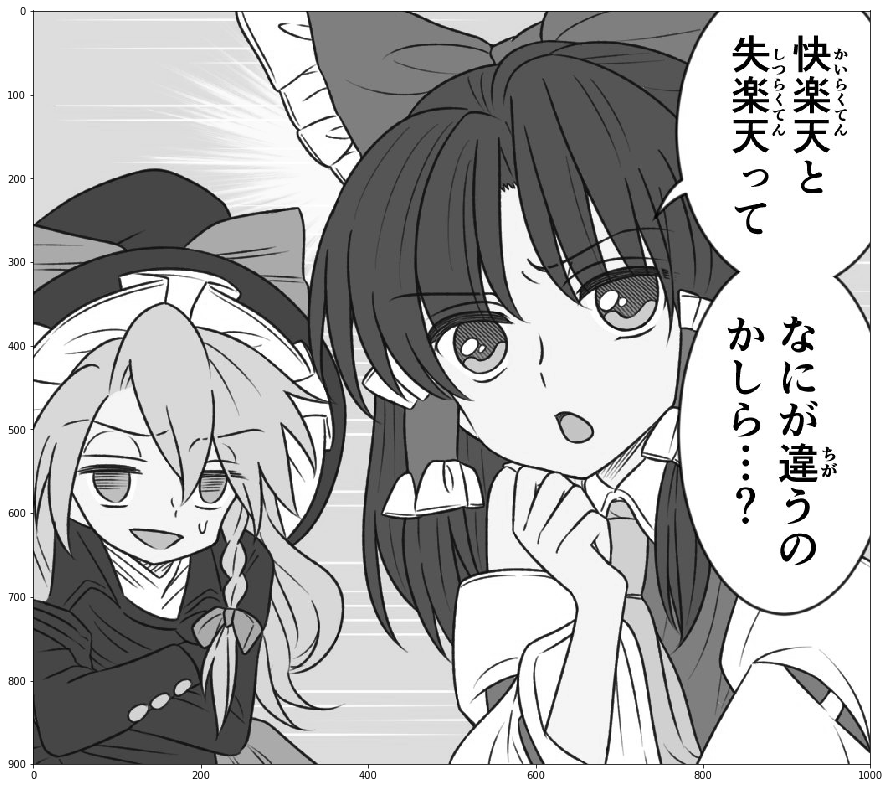

In [6]:
SRC = cv2.imread(INPUT_IMAGE)
SRC_GRAY = cv2.cvtColor(SRC, cv2.COLOR_BGR2GRAY)
HEIGHT, WIDTH = SRC.shape[:2]

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.imshow(SRC_GRAY, cmap='gray', interpolation='none')

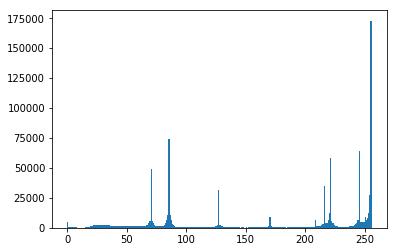

In [7]:
# SRC_GRAY's histogram

plt.hist(SRC_GRAY.ravel(),256,[0,256])
plt.show()

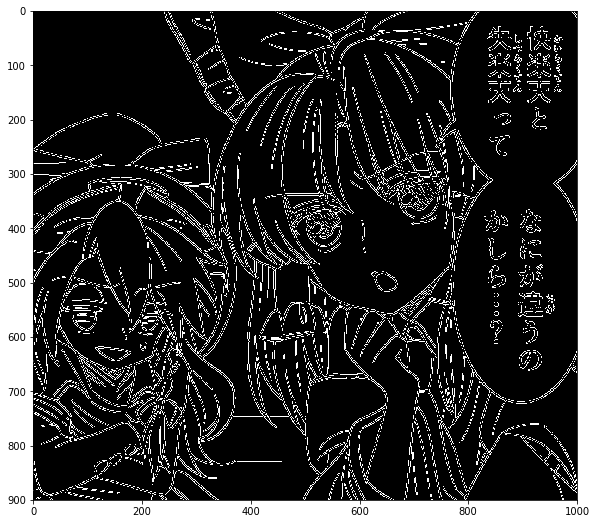

In [8]:
EDGES = cv2.Canny(SRC_GRAY, 100, 150)

division_size = 100
fig = plt.figure(figsize=(WIDTH/division_size, HEIGHT/division_size))
ax = fig.add_subplot(111)
ax.imshow(EDGES, cmap='gray', interpolation='none')

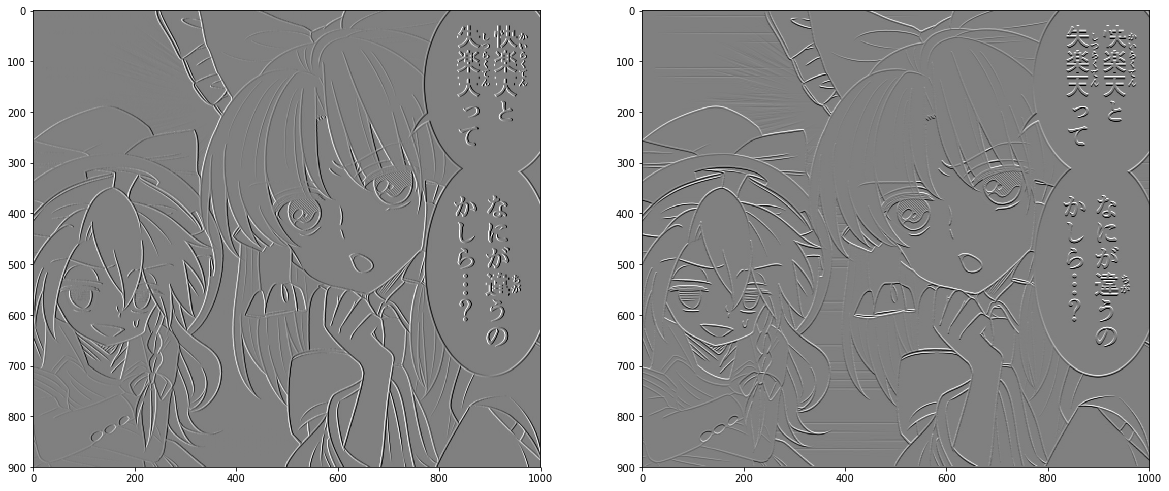

In [9]:
# Get Magnitude and gradient angel
        
invert_gray_image = cv2.bitwise_not(SRC_GRAY)
SOBEL_X = cv2.Sobel(invert_gray_image, cv2.CV_64F, 1, 0)
SOBEL_Y = cv2.Sobel(invert_gray_image, cv2.CV_64F, 0, 1)

fig = plt.figure(figsize=(WIDTH/50, HEIGHT/50))

ax = fig.add_subplot(121)
ax.imshow(SOBEL_X, cmap='gray', interpolation='none')

ax = fig.add_subplot(122)
ax.imshow(SOBEL_Y, cmap='gray', interpolation='none')

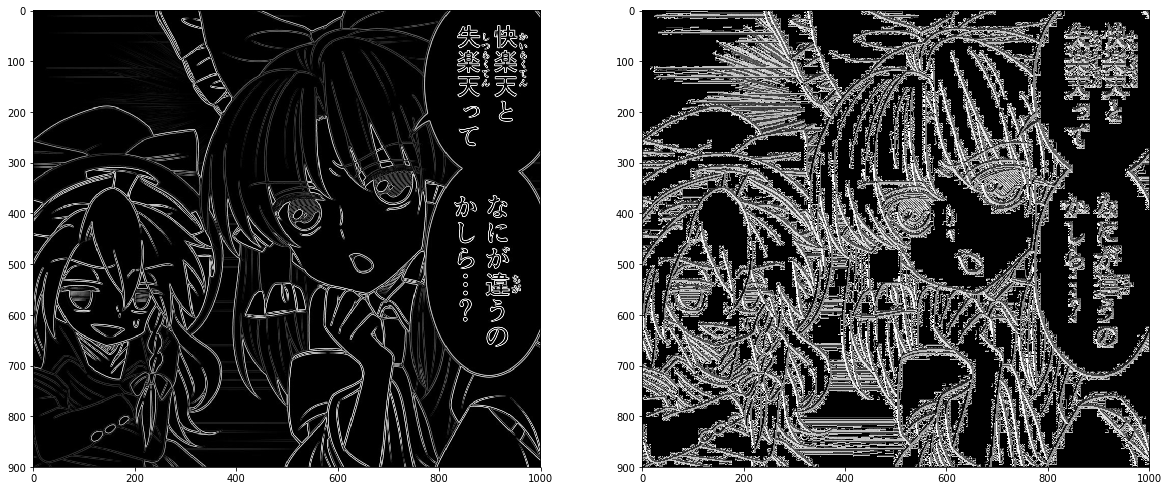

In [10]:
# Getting magnitude and direction of drawing

MAGNITUDE, DIRECTION = cv2.cartToPolar(SOBEL_X, SOBEL_Y)

fig = plt.figure(figsize=(WIDTH/50, HEIGHT/50))

ax = fig.add_subplot(121)
ax.imshow(MAGNITUDE, cmap='gray', interpolation='none')

ax = fig.add_subplot(122)
ax.imshow(DIRECTION, cmap='gray', interpolation='none')

In [11]:
# -2- Get swt step

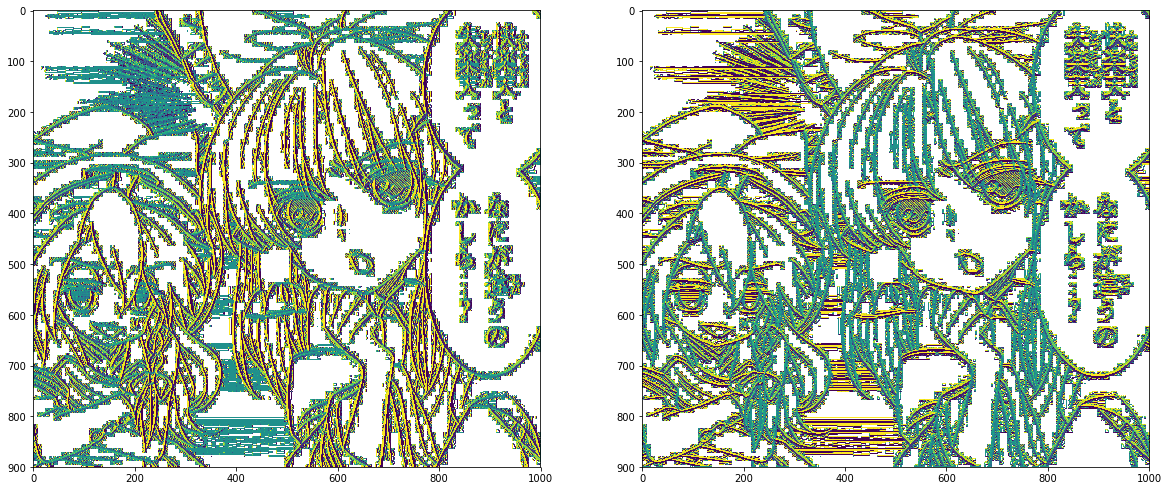

In [12]:
# Ignore error from divide by zero
np.seterr(divide='ignore', invalid='ignore')

step_x_g = SOBEL_X
step_y_g = SOBEL_Y

GRADIENT_X_GLOBAL = np.divide(step_x_g, MAGNITUDE)
GRADIENT_Y_GLOBAL = np.divide(step_y_g, MAGNITUDE)

fig = plt.figure(figsize=(WIDTH/50, HEIGHT/50))

ax = fig.add_subplot(121)
ax.imshow(GRADIENT_X_GLOBAL)

ax = fig.add_subplot(122)
ax.imshow(GRADIENT_Y_GLOBAL)

In [13]:
rays = []
temp_swt = np.full(EDGES.shape, np.Infinity)

for y in range(HEIGHT):
    for x in range(WIDTH):
        if EDGES[y][x] != 0:
            cur_x, cur_y = x, y
            gradient_x = GRADIENT_X_GLOBAL[y, x]
            gradient_y = GRADIENT_Y_GLOBAL[y, x]

            ray = [{'x': x, 'y': y}]
            i = 0

            while True:
                i += 1
                try:
                    cur_x = math.floor(x + gradient_x * i)
                    cur_y = math.floor(y + gradient_y * i)
                except ValueError:
                    # Catch Nan value when currenly position reached to outside a image
                    break

                try:
                    ray.append({'x': cur_x, 'y': cur_y})
                    if EDGES[cur_y][cur_x] != 0:
                        gradient_value = gradient_x * -GRADIENT_X_GLOBAL[cur_y, cur_x] + gradient_y * -GRADIENT_Y_GLOBAL[cur_y, cur_x]
                        
                        # Filter value which is out of domain
#                         if gradient_value >= -1 and gradient_value <= 1:
#                             if math.acos(gradient_x * -GRADIENT_X_GLOBAL[cur_y, cur_x] + gradient_y * -GRADIENT_Y_GLOBAL[cur_y, cur_x]) < np.pi/2.0:
#                                 thickness = math.sqrt( (cur_x - x) * (cur_x - x) + (cur_y - y) * (cur_y - y) )
#                                 rays.append(ray)

#                                 for pos in ray:
#                                     if min(thickness, temp_swt[pos['y'], pos['x']]) > 50:
#                                         continue
#                                     temp_swt[pos['y'], pos['x']] = min(thickness, temp_swt[pos['y'], pos['x']])
                        
                        if abs(abs(round(np.degrees(DIRECTION[y, x])) - round(np.degrees(DIRECTION[cur_y, cur_x]))) - 180) < 90:
                            thickness = math.sqrt( (cur_x - x) * (cur_x - x) + (cur_y - y) * (cur_y - y) )
                            rays.append(ray)

                            for pos in ray:
                                if min(thickness, temp_swt[pos['y'], pos['x']]) > 50:
                                    continue
                                temp_swt[pos['y'], pos['x']] = min(thickness, temp_swt[pos['y'], pos['x']])
                        break
                except IndexError:
                    break
                    
print('This step is DONE')

This step is DONE


In [14]:
for ray in rays:
    median = np.median([temp_swt[pos['y'], pos['x']] for pos in ray])
    for pos in ray:
        temp_swt[pos['y'], pos['x']] = min(median, temp_swt[pos['y'], pos['x']])
        
SWT = temp_swt

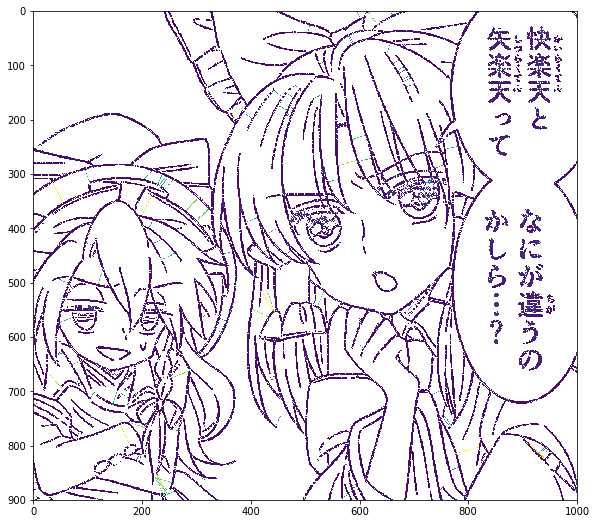

In [15]:
# %matplotlib notebook
# plt.imshow(swt)

divide_size = 100
fig = plt.figure(figsize=(WIDTH/divide_size, HEIGHT/divide_size))
ax = fig.add_subplot(111)
ax.imshow(SWT)

In [16]:
# Connect components

from collections import defaultdict
import numpy as np

def connect_components(swt):
    class Label(object):
        def __init__(self, value):
            self.value = value
            self.parent = self
            self.rank = 0

    ld = {}

    def MakeSet(x):
        try:
            return ld[x]
        except KeyError:
            item = Label(x)
            ld[x] = item
            return item

    def Find(item):
        if item.parent != item:
            item.parent = Find(item.parent)
        return item.parent

    def Union(x, y):
        """
        :param x:
        :param y:
        :return: root node of new union tree
        """
        x_root = Find(x)
        y_root = Find(y)
        if x_root == y_root:
            return x_root

        if x_root.rank < y_root.rank:
            x_root.parent = y_root
            return y_root
        elif x_root.rank > y_root.rank:
            y_root.parent = x_root
            return x_root
        else:
            y_root.parent = x_root
            x_root.rank += 1
            return x_root

    trees = {}
    label_map = np.zeros(shape=swt.shape, dtype=np.uint16)
    next_label = 1

    swt_ratio_threshold = 3.0
    for y in range(swt.shape[0]):
        for x in range(swt.shape[1]):

            sw_point = swt[y, x]
            if sw_point < np.Infinity and sw_point > 0:
                neighbors = [(y, x - 1),  # west
                             (y - 1, x - 1),  # northwest
                             (y - 1, x),  # north
                             (y - 1, x + 1)]  # northeast
                connected_neighbors = None
                neighborvals = []

                for neighbor in neighbors:
                    try:
                        sw_n = swt[neighbor]
                        label_n = label_map[neighbor]
                    except IndexError:
                        continue
                    if label_n > 0 and sw_n / sw_point < swt_ratio_threshold and sw_point / sw_n < swt_ratio_threshold:
                        neighborvals.append(label_n)
                        if connected_neighbors:
                            connected_neighbors = Union(connected_neighbors, MakeSet(label_n))
                        else:
                            connected_neighbors = MakeSet(label_n)

                if not connected_neighbors:
                    trees[next_label] = MakeSet(next_label)
                    label_map[y, x] = next_label
                    next_label += 1
                else:
                    label_map[y, x] = min(neighborvals)
                    trees[connected_neighbors.value] = Union(trees[connected_neighbors.value], connected_neighbors)

    layers = {}
    for x in range(swt.shape[1]):
        for y in range(swt.shape[0]):
            if label_map[y, x] > 0:
                item = ld[label_map[y, x]]
                common_label = Find(item).value
                label_map[y, x] = common_label
                try:
                    layer = layers[common_label]
                except KeyError:
                    layers[common_label] = np.zeros(shape=swt.shape, dtype=np.uint16)
                    layer = layers[common_label]

                layer[y, x] = 1
    return (layers, label_map)

In [17]:
t0 = time.time()
CONNECTED_COMP_DICT, label_map = connect_components(SWT)
t1 = time.time()

print('processing time:', t1-t0, 'seconds')

processing time: 5.468840837478638 seconds


In [18]:
paper = np.zeros(SWT.shape)
cnt = 1
for i in CONNECTED_COMP_DICT:
    blank = np.full(SWT.shape, cnt)
    mask = CONNECTED_COMP_DICT[i].astype('uint8')
    
    # Remove noise pixel
    if sum(sum(CONNECTED_COMP_DICT[i])) <= 1:
        continue
    
    paper = paper + cv2.bitwise_and(blank, blank, mask=mask)
    cnt = cnt + 1

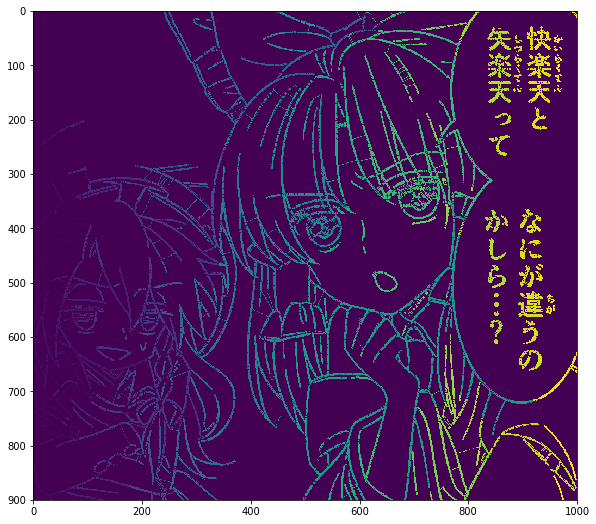

In [19]:
divide_size
fig = plt.figure(figsize=(WIDTH/divide_size, HEIGHT/divide_size))
ax = fig.add_subplot(111)
ax.imshow(paper)

In [20]:
# Find Letters
def find_letters(swt, shapes):
    swts = []
    heights = []
    widths = []
    topleft_pts = []
    images = []

    for label, layer in shapes.items():
        (nz_y, nz_x) = np.nonzero(layer)
        east, west, south, north = max(nz_x), min(nz_x), max(nz_y), min(nz_y)
        width, height = east - west, south - north

        if height < 10 or height > 300:
            continue

        diameter = math.sqrt(width * width + height * height)
        median_swt = np.median(swt[(nz_y, nz_x)])
        if diameter / median_swt > 10:
            continue

        # we use log_base_2 so we can do linear distance comparison later using k-d tree
        # ie, if log2(x) - log2(y) > 1, we know that x > 2*y
        # Assumption: we've eliminated anything with median_swt == 1
        swts.append([math.log(median_swt, 2)])
        heights.append([math.log(height, 2)])
        topleft_pts.append(np.asarray([north, west]))
        widths.append(width)
        images.append(layer)

    print("len(swts):", len(swts))

    return swts, heights, widths, topleft_pts, images

In [22]:
letter_swt_values, letter_heights, letter_widths, letter_topleft_pts, letter_images = find_letters(SWT, CONNECTED_COMP_DICT)

len(swts): 145


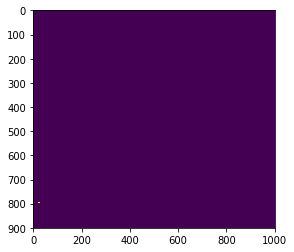

In [27]:
plt.imshow(letter_images[2])